# Convolutational Network to identify 349 bird species

In this notebook we use a dataset from *Kaggle* as an exercise to study convolutional networks: The [dataset used](https://www.kaggle.com/gpiosenka/100-bird-species) contains labelled fotos of 349 bird species. We train a neural network to identify the bird species based upon an image.

See *Results* section for some actual images with correct and predicted labels. This requires a copy of the dataset. Since it is constanly updated with more bird species, [I have uploaded the exact version I am using.](https://we.tl/t-D04oRMZcZv)

We will use `tensorflow.keras` for this.

In [1]:
import glob
from math import ceil
from matplotlib import image, pyplot
import numpy as np
from random import shuffle
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence, to_categorical

Let's specify the topology of the neural network we are going to use and also fix some hyperparameters

In [16]:
no_of_conv_layers = 3
no_of_filters = 10
kernel_size = (5, 5)
pool_size = (2, 2)
batch_size = 32
epochs = 300
dropout_rate = 0.35
input_shape = (224, 224, 3)

Let's define an utility function to load the data. The data set is separated into three folders *train*, *test* and *valid*, which we will use as such. The following function finds all images in the three image_sets and makes a list of tuples where the first value is the bird's name (=label) and the second value is the image's path.

In [3]:
def get_paths_and_labels(image_set):
    assert image_set in ['train', 'test', 'valid']

    all_bird_names = [path[14+len(image_set):] for path in glob.glob('bird-species/' + image_set + '/*')]

    image_list = []
    label_list = []
    for l in all_bird_names:
        image_list += [link for link in glob.glob('bird-species/' + image_set + '/' + l + '/*')]
        label_list += [l]*len(glob.glob('bird-species/' + image_set + '/' + l + '/*'))
        
    return image_list, label_list

We use it to load the data for train and validation set and also derive a list of unique alphabetized labels (= names of bird species)

In [4]:
train_img_list, train_label_list = get_paths_and_labels('train')
valid_img_list, valid_label_list = get_paths_and_labels('valid')
alphabetized_labels = sorted(list(set(train_label_list)))
target_size = len(alphabetized_labels)

In order to facilitate the training process we define a utility class that generates training data from the images, such that we don't have to load them into the memory all at once:

In [5]:
class BatchGenerator(Sequence):
    def __init__(self, image_list, label_list, alphabetized_labels, batch_size, augment_data=False):
        self.batch_size = batch_size
        self.image_paths = image_list
        self.alphabetized_labels = alphabetized_labels

        # the image loader function
        self.pixels = lambda path: np.array(image.imread(path)) / 256

        # turn the label list into a list of indices and then turn them into one-hot vectors
        label_indices = list(map(lambda x: self.alphabetized_labels.index(x), label_list))
        self.targets = to_categorical(label_indices, num_classes=len(set(label_indices)))

        # shuffle the indices in each epoch
        self.indices = list(range(len(image_list)))
        self.shuffle()

    def __len__(self):
        ''' returns the total number of batches '''
        no_of_images = len(self.image_paths)
        return ceil(no_of_images/self.batch_size)

    def __getitem__(self, index):
        # get the indices corresponding to the current batch
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]

        # get the corresponding file paths
        batch_paths = [self.image_paths[i] for i in batch_indices]

        # load the targets and load the image data from file
        batch_targets = np.array([self.targets[i] for i in batch_indices])
        batch_inp = np.array([self.pixels(p) for p in batch_paths])
        
        return batch_inp, batch_targets

    def shuffle(self):
        shuffle(self.indices)

We now initialize a generator for the training data and another one for the validation data.

In [6]:
train_generator = BatchGenerator(image_list=train_img_list, label_list=train_label_list, alphabetized_labels=alphabetized_labels, batch_size=batch_size)
valid_generator = BatchGenerator(image_list=valid_img_list, label_list=valid_label_list, alphabetized_labels=alphabetized_labels, batch_size=batch_size)

## The neural network
We are now ready to define our neural network based upon the hyperparameters given above.

(Note, that applying *BatchNormalization* and/or *Dropout* after each convolutional layer did not show any improvement empirically)

Given that we run many epochs over the same data, overfitting is quite probable. Empirically applying the Dropout-layer as done below does a good job at prohibiting this. (This typically causes the accuracy to be lower in training than in validating/testing when we switch off this layer)

In [7]:
main_input = Input(shape=input_shape, dtype='float32', name='main_input')
x = main_input

for i in range(no_of_conv_layers):
    x = Conv2D(filters=no_of_filters, kernel_size=kernel_size, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=pool_size)(x)

x = Flatten()(x)
x = Dropout(rate=dropout_rate)(x)
main_output = Dense(target_size, activation='softmax', name='main_output')(x)

2022-02-13 19:12:13.976894: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Finally, we can specify the optimizer, loss-function and metric:

In [8]:
optimizer = Adadelta()
model = Model(inputs=main_input, outputs=main_output)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Before we run the training, we also define a path to save our weights to and define at which frequency the weights will be saved during the training process:

In [9]:
weights_file_path = "bird_weights.hdf5"
callbacks_list = [ModelCheckpoint(weights_file_path, monitor='loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)]

## Training the model
Finally we are ready to train the model:

In [ ]:
model.load_weights(weights_file_path)
model.fit(x=train_generator, validation_data=valid_generator, epochs=epochs, callbacks=callbacks_list)
model.save_weights(weights_file_path)

## Results
Let us get some statistics on how well the model performs on the test data set!

(Note, that existing weights can be loaded with the commented out line)

In [18]:
#model.load_weights("bird_weights_demo.hdf5")
test_img_list, test_label_list = get_paths_and_labels('test')
test_generator = BatchGenerator(image_list=test_img_list, label_list=test_label_list, alphabetized_labels=alphabetized_labels, batch_size=999999)
inp, target = test_generator[0]
score = model.evaluate(inp, target)
print("Score on the test set: ", score)

55/55 [==============================] - 5s 89ms/step - loss: 3.1387 - accuracy: 0.3605
Score on the test set:  [3.138735294342041, 0.36045846343040466]


After 300 epochs the accuracy still increased, but it already reached 36%. Compared with a random guess (0.3%) this is significantly better. That is the network picked up on some things. It would be interesting to see how the speed of convergence depends on some of the parameters. Especially the dropout-rate has been chosen very high due to problems with overfitting. I still suspect that it is much too high and a lower value would lead to faster convergence.

To also get an intuitive understanding of the performance of our model, let's show and image and then print both correct and predicted label.

real label:  D-ARNAUDS BARBET 	predicted label:  STRIPED OWL


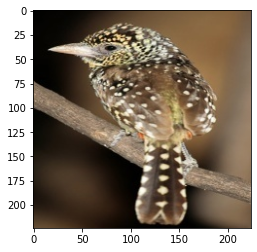

real label:  QUETZAL 	predicted label:  BEARDED BARBET


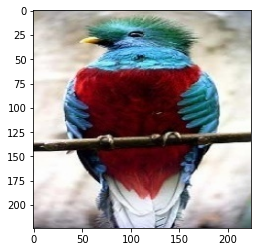

real label:  WHITE BROWED CRAKE 	predicted label:  SORA


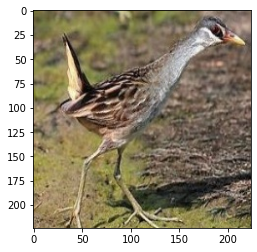

real label:  REGENT BOWERBIRD 	predicted label:  CAPE GLOSSY STARLING


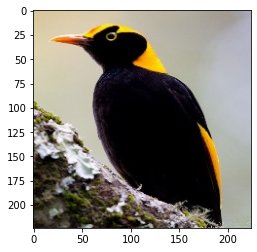

real label:  AFRICAN OYSTER CATCHER 	predicted label:  AFRICAN OYSTER CATCHER


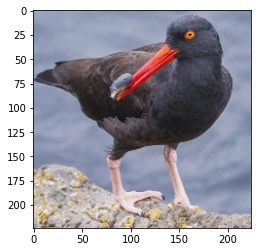

real label:  STRIPED OWL 	predicted label:  DOWNY WOODPECKER


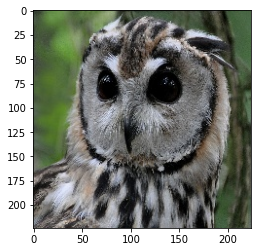

real label:  CHIPPING SPARROW 	predicted label:  LONG-EARED OWL


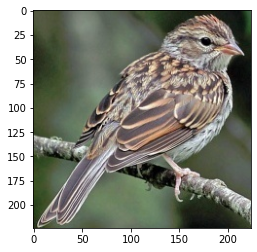

real label:  PARAKETT  AKULET 	predicted label:  PARAKETT  AKULET


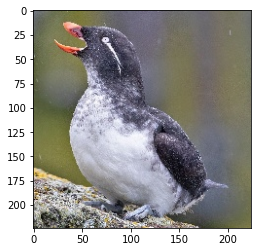

real label:  SHORT BILLED DOWITCHER 	predicted label:  TEAL DUCK


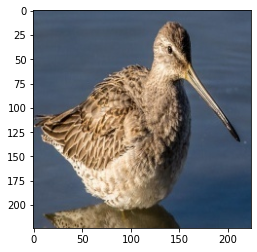

real label:  AMERICAN PIPIT 	predicted label:  BEARDED REEDLING


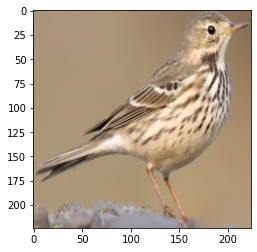

real label:  CHIPPING SPARROW 	predicted label:  WHIMBREL


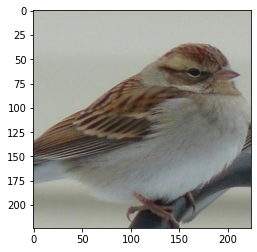

real label:  ALBERTS TOWHEE 	predicted label:  ALBERTS TOWHEE


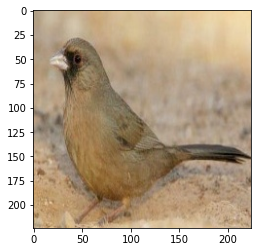

real label:  AZURE TANAGER 	predicted label:  AZURE TANAGER


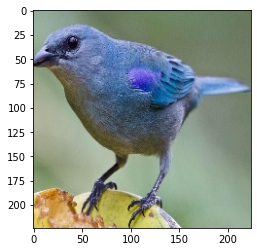

real label:  GRAY CATBIRD 	predicted label:  GRAY CATBIRD


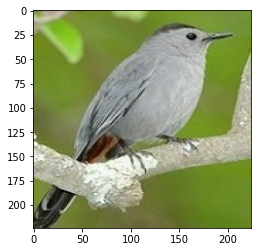

real label:  BARROWS GOLDENEYE 	predicted label:  BARROWS GOLDENEYE


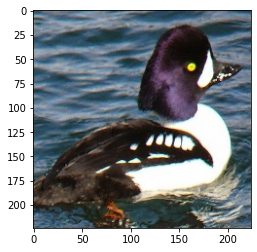

real label:  CRESTED AUKLET 	predicted label:  CRESTED AUKLET


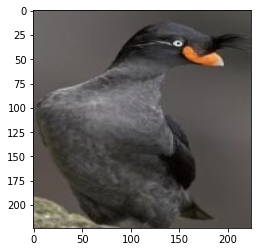

real label:  HARPY EAGLE 	predicted label:  COLLARED ARACARI


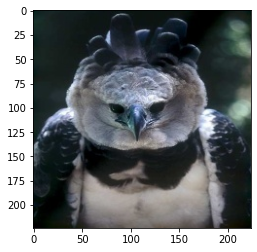

real label:  SORA 	predicted label:  KILLDEAR


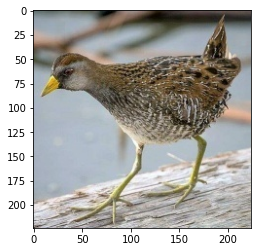

real label:  HOUSE FINCH 	predicted label:  HOUSE FINCH


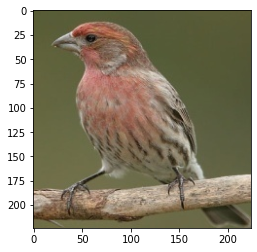

real label:  LONG-EARED OWL 	predicted label:  RED TAILED HAWK


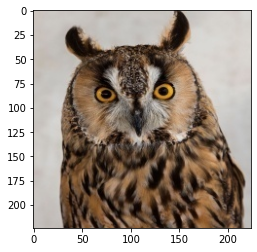

In [19]:
def show_image(pixels):
    pyplot.imshow(pixels)
    pyplot.show()

no_of_images_to_show = 20    
res = model.predict(inp)
for i in range(no_of_images_to_show):
    print('real label: ', alphabetized_labels[np.argmax(target[i])], "\tpredicted label: ", alphabetized_labels[np.argmax(res[i])])
    show_image(inp[i])

## Possible improvements:
* Use data augmentation (i.e. change image brightness, rotate it, zoom it, ...)
* Use some pre-trained convolutional layers in the lowest layers of the network
* Investigate better on which dropout value prevents overfitting but allows for faster convergence